# Deep NeuralNetwork _ from scratch

```
[Option]

1. Number of neurons (hidden layer, output layer)
2. Loss function
    - Mean Squard Error
    - Softmax Cross Entorpy
3. Activation function
    - Linear
    - Sigmoid
    - ReLU
    - Tanh
4. Optimizer
    - SGD
    - SGD with momentum
5. Weight initializer
6. Learning rate decay
7. Dropout
```

In [1]:
import numpy as np
from numpy import ndarray

from typing import List

In [2]:
def assert_same_shape(array: np.ndarray,
                      array_grad: np.ndarray):
    assert array.shape == array_grad.shape, \
        '''
        두 ndarray의 모양이 같아야 하는데,
        첫 번째 ndarray의 모양은 {0}이고,
        두 번째 ndarray의 모양은 {1}이다.
        '''.format(tuple(array.shape),tuple(array_grad.shape))
    return None

In [3]:
class Operation:
    '''
    신경망 모델의 연산의 최상위 Abstracdt class
    '''
    def __init__(self):
        pass
    
    def forward(self, input_: np.ndarray, inference: bool=False)->np.ndarray:
        self.input_ = input_
        self.output = self._output(inference)
        return self.output
    
    def backward(self, output_grad: np.ndarray)->np.ndarray:
        '''
        self._input_grad() 호출함
        이때, 모양의 일치여부 확인 필요
        '''
        
        assert_same_shape(self.output, output_grad)
    
        self.input_grad = self._input_grad(output_grad)
        assert_same_shape(self.input_, self.input_grad)
        
        return self.input_grad
    
    def _output(self, inference: bool)->np.ndarray:
        '''
        Operation클래스의 concrete class(Subclasses of ParamOperation class)에서 
        _output 메서드 구현해야 함
        '''
        raise NotImplementedError()
        
    def _input_grad(self, output_grad: np.ndarray)->np.ndarray:
        '''
        Operation을 구현한 모든 구상 클래스는 _input_grad 메서드를 구현해야 한다.
        '''
        raise NotImplementedError()


In [4]:
class ParamOperation(Operation):
    '''
    파라미터를 갖는 모든 연산의 Abstract class
    '''
    
    def __init__(self, param: np.ndarray):
        '''
        생성자 메서드
        '''
        super().__init__()
        self.param = param
        
    def backward(self, output_grad: np.ndarray)->np.ndarray:
        '''
        self._input_grad(), self._output_grad() 호출
        이때, 모양의 일치 여부 확인 필요
        '''
        assert_same_shape(self.output, output_grad)
        
        self.input_grad = self._input_grad(output_grad)
        self.param_grad = self._param_grad(output_grad)
        
        assert_same_shape(self.input_, self.input_grad)
        assert_same_shape(self.param, self.param_grad)
        
        return self.input_grad
    
    def _param_grad(self,output_grad):
        '''
        Operation을 구현한 모든 구상 클래스는 _param_grad 메서드를 구현해야 한다.
        '''
        raise NotImplementedError()
    

In [5]:
class WeightMultiply(ParamOperation):
    '''
    가중치 행렬곱 연산
    '''
    
    def __init__(self, W: np.ndarray):
        '''
        self.paran = W 로 초기화
        '''
        super().__init__(W)
        
    def _output(self,inference: bool)->np.ndarray:
        '''
        출력값 계산
        '''
        return np.dot(self.input_, self.param)
    
    def _input_grad(self, output_grad :np.ndarray)->np.ndarray:
        '''
        입력에 대한 gradient 계산
        '''
        return np.dot(output_grad, np.transpose(self.param,(1,0)))
        
    def _param_grad(self, output_grad :np.ndarray)->np.ndarray:
        '''
        파라미터(W)에 대한 gradient 계산
        '''
        return np.dot(np.transpose(self.input_,(1,0)), output_grad)

In [6]:
class BiasAdd(ParamOperation):
    '''
    편향을 더하는 연산
    '''
    
    def __init__(self, B: np.ndarray):
        '''
        self.paran = B 로 초기화
        초기화 전에 행렬의 모양 확인 필요
        '''
        assert B.shape[0] == 1
        super().__init__(B)
        
    def _output(self,inference: bool)->np.ndarray:
        '''
        출력값 계산
        '''
        return self.input_ + self.param
    
    def _input_grad(self, output_grad :np.ndarray)->np.ndarray:
        '''
        입력값에 대한 gradient 계산
        '''
        # * 연산 순서 전환 디버깅함
        return np.ones_like(self.input_)*output_grad
    
    def _param_grad(self, output_grad :np.ndarray)->np.ndarray:
        '''
        파라미터에 대한 gradient 계산
        '''
        # * 연산 순서 전환 디버깅함
        param_grad = np.ones_like(self.param)*output_grad
        return np.sum(param_grad, axis=0).reshape(1, param_grad.shape[1])
        

In [7]:
class Sigmoid(Operation):
    '''
    sigmoid 활성화 함수
    '''
    
    def __init__(self)->None:
        '''pass'''
        super().__init__()
        
    def _output(self,inference: bool)->np.ndarray:
        '''
        출력값 계산
        '''
        return 1.0/(1.0 + np.exp(-1.0 * self.input_))
    
    def _input_grad(self, output_grad :np.ndarray)->np.ndarray:
        '''
        입력에 대한 gradient 계산
        '''
        sigmoid_backward = self.output * (1.0 - self.output)
        # * 연산 순서 전환 디버깅함
        input_grad = sigmoid_backward*output_grad
        return input_grad
    

In [8]:
class Linear(Operation):
    '''
    항등 활성화 함수
    '''

    def __init__(self) -> None:
        '''기반 클래스의 생성자 메서드 실행'''        
        super().__init__()

    def _output(self, inference: bool) -> np.ndarray:
        '''입력을 그대로 출력'''
        return self.input_

    def _input_grad(self, output_grad: np.ndarray) -> np.ndarray:
        '''그대로 출력'''
        return output_grad

In [9]:
class Tanh(Operation):
    '''
    Hyperbolic tangent activation function
    '''
    def __init__(self) -> None:
        super().__init__()

    def _output(self, inference: bool) -> ndarray:
        return np.tanh(self.input_)

    def _input_grad(self, output_grad: ndarray) -> ndarray:

        return output_grad * (1 - self.output * self.output)

In [10]:
class ReLU(Operation):
    '''
    Hyperbolic tangent activation function
    '''
    def __init__(self) -> None:
        super().__init__()

    def _output(self, inference: bool) -> ndarray:
        return np.clip(self.input_, 0, None)

    def _input_grad(self, output_grad: ndarray) -> ndarray:

        mask = self.output >= 0
        return output_grad * mask

In [11]:
class Layer(object):
    '''
    신경망 모델의 층 역할을 하는 클래스
    '''
    
    def __init__(self, neurons :int, dropout: float = 1.0):
        '''
        뉴런의 갯수 생성
        '''
        self.neurons = neurons
        self.first = True
        self.params :List[np.ndarray] = []
        self.param_grads :List[np.ndarray] = []
        self.operations :List[Operation] = []
            
    def _setup_layer(self, num_in: int)->None:
        '''
        Layer를 구현하는 concrete class는 _setup_layer 메서드를 구현해야 함
        '''
        raise NotImplementedError()
        
    def forward(self, input_ :np.ndarray, inference=False)->np.ndarray:
        '''
        입력값을 각 연산에 순서대로 통과시켜 순방향 계산을 수행함
        '''
        if self.first:
            self._setup_layer(input_)
            self.first = False
        
        self.input_ = input_
        # Operation.forward(): 안에서 self.input_ 이 update됨
        for operation in self.operations:
            input_ = operation.forward(input_, inference)
            
        self.output = input_
        
        return self.output
    
    def backward(self, output_grad :np.ndarray)->np.ndarray:
        '''
        output_grad를 각 연산에 역순으로 통과시켜 backprop 시행
        계산하기 전, 행렬의 모양을 확인한다.
        forward모두 수행 후(self.operations 모두 채워진 상태), backward 수행
        '''
        assert_same_shape(self.output, output_grad)
        
        for operation in reversed(self.operations):
            output_grad = operation.backward(output_grad)
            
        input_grad = output_grad
        
        self._param_grads()
        
        return input_grad
    
    def _param_grads(self):
        '''
        각 operation 객체에서 _param_grad값을 꺼내 저장
        '''
        
        self.param_grads = []
        for operation in self.operations:
            if issubclass(operation.__class__, ParamOperation):
                self.param_grads.append(operation.param_grad)
    
    def _params(self):
        '''
        각 operation 객체에서 _param값을 꺼내 저장
        '''
        
        self.params = []
        for operation in self.operations:
            if issubclass(operation.__class__, ParamOperation):
                self.params.append(operation.param)        
          

In [12]:
from typing import*

class Dense(Layer):
    '''
    Layer 클래스의 sequence(self.operations)의 concrete class
    Dense : Layer들의 fully_connected 구성
    '''
    
    def __init__(self, neurons :int, dropout: float = 1.0, activation = Sigmoid(),
                 weight_init: str = "standard")->None:
        '''
        Dense 생성(초기화) 시, Layer의 상속 외에도
        activation을 추가로 지정해야 함
        '''
        super().__init__(neurons)
        self.activation = activation
        self.dropout = dropout
        self.weight_init = weight_init
    
    def _setup_layer(self, input_ :np.ndarray):
        '''
        Dense의 연산 정의
        연산 Sequence 구조 구현
        '''
        if self.seed:
            np.random.seed(self.seed)
            
        if self.weight_init == "glorot":
            scale = 2/(num_in + self.neurons)
        else:
            scale = 1.0
            
        self.params = []
        
        # W 초기값 생성
        self.params.append(np.random.randn(input_.shape[1],self.neurons))
        # Bias 초기값 생성
        self.params.append(np.random.randn(1,self.neurons))
        
        # sequence 초기값 설정
        self.operations = [WeightMultiply(self.params[0]),
                           BiasAdd(self.params[1]),
                           self.activation]
        
        if self.dropout < 1.0:
            self.operations.append(Dropout(self.dropout))        
        
        return None

In [13]:
class Loss(object):
    '''
    신경망 모델의 손실을 계산하는 클래스
    '''
    
    def __init__(self):
        '''pass'''
        pass
    
    def forward(self, prediction :np.ndarray, target :np.ndarray)->float:
        '''
        실제 Loss값 계산
        '''
        # 새로 생성
#         prediction = np.sum(prediction,axis=1).reshape(-1,1)
        
        assert_same_shape(prediction,target)
        
        self.prediction = prediction
        self.target = target
        
        loss_value = self._output()
        
        return loss_value
    
    def backward(self)->np.ndarray:
        '''
        손실함수의 입력값에 대해 손실의 gradient 계산함
        '''
        self.input_grad = self._input_grad()
        
        assert_same_shape(self.prediction, self.input_grad)
        
        return self.input_grad
    
    def _output(self)->float:
        '''
        Loss class를 확장한 concrete class는 _output 메서드를 구현해야 함
        '''
        raise NotImplementedError
        
    def _input_grad(self)->np.ndarray:
        '''
        Loss class를 확장한 concrete class는 _input_grad 메서드를 구현해야 함
        '''
        raise NotImplementedError

In [14]:
class MeanSquaredError(Loss):
    
    def __init__(self):
        super().__init__()
    
    def _output(self)->float:
        loss = (np.sum(np.power(self.prediction - self.target,2))/self.prediction.shape[0])
        return loss
    
    def _input_grad(self)->np.ndarray:
        return 2.0*(self.prediction - self.target) / self.prediction.shape[0]
        

In [15]:
class NeuralNetwork:
    '''
    신경망을 나타내는 클래스
    '''
    def __init__(self, layers :List[Layer], loss :Loss, seed :int = 1):
        '''
        신경망의 층, 손실함수를 정의
        '''
        self.layers = layers
        self.loss = loss
        self.seed = seed
        
        # layer가 갖고 있는 seed값을 self.seed로 변경하도록 하는 코드
        # setattr(object, name, value) := object에 존재하는 속성의 값을 바꾸거나, 새로운 속성을 생성하여 값을 부여함
        if seed:
            for layer in self.layers:
                setattr(layer, "seed", self.seed)
        
    def forward(self, x_batch :np.ndarray, inference: bool = False)->np.ndarray:
        '''
        데이터를 각 층에 순서대로 통과시킴(순방향 계산)
        '''
        x_out = x_batch
        for layer in self.layers:
            x_out = layer.forward(x_out,inference)
        
        return x_out
    
    def backward(self, loss_grad :np.ndarray)->None:
        '''
        데이터를 각 층에 역순으로 통과시킴(역방향 계산)
        '''
        grad = loss_grad
        # reversed 하지않아 디버깅함
        for layer in reversed(self.layers):
            grad = layer.backward(grad)
            
        return None
    
    def train_batch(self, x_batch :np.ndarray, y_batch :np.ndarray)->float:
        '''
        1. foward
        2. get_loss
        3. backward
        '''
        predictions = self.forward(x_batch)
        loss = self.loss.forward(predictions, y_batch)
        self.backward(self.loss.backward())
        
        return loss
    
    def params(self):
        '''
        신경망의 param 값을 받음
        '''
        for layer in self.layers:
            yield from layer.params
            
    def param_grads(self):
        '''
        신경망의 각 param에 대한 param_grad 값을 받음
        '''
        for layer in self.layers:
            yield from layer.param_grads
    

In [16]:
class Optimizer:
    '''
    신경망 최적화 기능을 제공하는 Abstract class
    '''
    def __init__(self, lr :float = 0.01, final_lr: float=0, decay_type: str='exponential'):
        '''
        최초의 learning_rate 가 반드시 설정되어야 함
        '''
        self.lr = lr
        self.final_lr = final_lr
        self.decay_type = decay_type
        
    def step(self,
             epoch: int = 0) -> None:

        for (param, param_grad) in zip(self.net.params(),
                                       self.net.param_grads()):
            self._update_rule(param=param,
                              grad=param_grad)

    def _update_rule(self, **kwargs) -> None:
        raise NotImplementedError()
    
    def _setup_decay(self) -> None:

        if not self.decay_type:
            return
        elif self.decay_type == 'exponential':
            self.decay_per_epoch = np.power(self.final_lr / self.lr,
                                       1.0 / (self.max_epochs - 1))
        elif self.decay_type == 'linear':
            self.decay_per_epoch = (self.lr - self.final_lr) / (self.max_epochs - 1)

    def _decay_lr(self) -> None:

        if not self.decay_type:
            return

        if self.decay_type == 'exponential':
            self.lr *= self.decay_per_epoch

        elif self.decay_type == 'linear':
            self.lr -= self.decay_per_epoch

In [17]:
class SGD(Optimizer):
    '''
    확률적 경사 하강법을 적용한 Optimizer
    '''
    def __init__(self,
                 lr: float = 0.01,
                 final_lr: float = 0,
                 decay_type: str = None) -> None:
        super().__init__(lr, final_lr, decay_type)
        
    def step(self):
        '''
        각 parameter에 learning rate를 곱해 gradient 방향으로 parameter를 수정
        '''
        for (param, param_grad) in zip(self.net.params(),
                                       self.net.param_grads()):
            param -= self.lr * param_grad
    
    def _update_rule(self, **kwargs) -> None:

        update = self.lr*kwargs['grad']
        kwargs['param'] -= update

In [18]:
class SGDMomentum(Optimizer):
    def __init__(self,
                 lr: float = 0.01,
                 final_lr: float = 0,
                 decay_type: str = None,
                 momentum: float = 0.9) -> None:
        super().__init__(lr, final_lr, decay_type)
        self.momentum = momentum

    def step(self) -> None:
        if self.first:
            self.velocities = [np.zeros_like(param)
                               for param in self.net.params()]
            self.first = False

        for (param, param_grad, velocity) in zip(self.net.params(),
                                                 self.net.param_grads(),
                                                 self.velocities):
            self._update_rule(param=param,
                              grad=param_grad,
                              velocity=velocity)

    def _update_rule(self, **kwargs) -> None:

            # Update velocity
            kwargs['velocity'] *= self.momentum
            kwargs['velocity'] += self.lr * kwargs['grad']

            # Use this to update parameters
            kwargs['param'] -= kwargs['velocity']

In [19]:
class Dropout(Operation):

    def __init__(self,
                 keep_prob: float = 0.8):
        super().__init__()
        self.keep_prob = keep_prob

    def _output(self, inference: bool) -> ndarray:
        if inference:
            return self.input_ * self.keep_prob
        else:
            self.mask = np.random.binomial(1, self.keep_prob,
                                           size=self.input_.shape)
            return self.input_ * self.mask

    def _input_grad(self, output_grad: ndarray) -> ndarray:
        return output_grad * self.mask

In [20]:
from copy import deepcopy
from typing import Tuple

class Trainer(object):
    '''
    신경망 모델을 학습시키는 역할을 수행함
    '''
    def __init__(self,
                 net: NeuralNetwork,
                 optim: Optimizer) -> None:
        '''
        학습을 수행하려면 NeuralNetwork, Optimizer 객체가 필요함
        Optimizer 객체의 인스턴스 변수로 NeuralNetwork 객체를 전달할 것
        '''
        self.net = net
        self.optim = optim
        self.best_loss = 1e9
        setattr(self.optim, 'net', self.net)
        
    def generate_batches(self,
                         X: ndarray,
                         y: ndarray,
                         size: int = 32) -> Tuple[ndarray]:
        '''
        배치 생성 
        '''
        assert X.shape[0] == y.shape[0], \
        '''
        특징과 목푯값은 행의 수가 같아야 하는데,
        특징은 {0}행, 목푯값은 {1}행이다
        '''.format(X.shape[0], y.shape[0])

        N = X.shape[0]

        for ii in range(0, N, size):
            X_batch, y_batch = X[ii:ii+size], y[ii:ii+size]

            yield X_batch, y_batch

            
    def fit(self, X_train: ndarray, y_train: ndarray,
            X_test: ndarray, y_test: ndarray,
            epochs: int=100,
            eval_every: int=10,
            batch_size: int=32,
            seed: int = 1,
            restart: bool = True)-> None:
        '''
        일정 횟수의 에폭을 수행하며 학습 데이터에 신경망을 최적화함
        eval_every 변수에 설정된 횟수의 매 에폭마다 테스트 데이터로
        신경망의 예측 성능을 측정함
        '''

        np.random.seed(seed)
        if restart:
            for layer in self.net.layers:
                layer.first = True

            self.best_loss = 1e9

        for e in range(epochs):

            if (e+1) % eval_every == 0:
                
                # 조기 종료
                last_model = deepcopy(self.net)

            X_train, y_train = permute_data(X_train, y_train)

            batch_generator = self.generate_batches(X_train, y_train,
                                                    batch_size)

            for ii, (X_batch, y_batch) in enumerate(batch_generator):

                self.net.train_batch(X_batch, y_batch)

                self.optim.step()

            if (e+1) % eval_every == 0:

                test_preds = self.net.forward(X_test, inference=True)
                loss = self.net.loss.forward(test_preds, y_test)

                if loss < self.best_loss:
                    print(f"{e+1} 에폭에서 검증 데이터에 대한 손실값: {loss:.3f}")
                    self.best_loss = loss
                else:
                    print(f"""{e+1}에폭에서 손실값이 증가했다. 마지막으로 측정한 손실값은 {e+1-eval_every}에폭까지 학습된 모델에서 계산된 {self.best_loss:.3f}이다.""")
                    self.net = last_model
                    # self.optim이 self.net을 수정하도록 다시 설정
                    setattr(self.optim, 'net', self.net)
                    break
                
            if self.optim.final_lr:
                self.optim._decay_lr()

**평가기준**

In [21]:
def mae(y_true: ndarray, y_pred: ndarray):
    '''
    신경망 모델의 평균절대오차 계산
    '''    
    return np.mean(np.abs(y_true - y_pred))

def rmse(y_true: ndarray, y_pred: ndarray):
    '''
    신경망 모델의 제곱근 평균제곱오차 계산
    '''
    return np.sqrt(np.mean(np.power(y_true - y_pred, 2)))

def eval_regression_model(model: NeuralNetwork,
                          X_test: ndarray,
                          y_test: ndarray):
    '''
    신경망 모델의 평균절대오차 및 제곱근 평균제곱오차 계산
    Compute mae and rmse for a neural network.
    '''
    preds = model.forward(X_test)
    preds = preds.reshape(-1, 1)
    print("평균절대오차: {:.2f}".format(mae(preds, y_test)))
    print()
    print("제곱근 평균제곱오차 {:.2f}".format(rmse(preds, y_test)))

In [22]:
lr = NeuralNetwork(
    layers=[Dense(neurons=1,
                   activation=Linear())],
    loss=MeanSquaredError(),
    seed=20190501
)

nn = NeuralNetwork(
    layers=[Dense(neurons=13,
                   activation=Sigmoid()),
            Dense(neurons=1,
                   activation=Linear())],
    loss=MeanSquaredError(),
    seed=20190501
)

dl = NeuralNetwork(
    layers=[Dense(neurons=13,
                   activation=Sigmoid()),
            Dense(neurons=13,
                   activation=Sigmoid()),
            Dense(neurons=1,
                   activation=Linear())],
    loss=MeanSquaredError(),
    seed=20190501
)

**데이터 로드, 테스트 / 학습 데이터 분할**

In [23]:
from sklearn.datasets import load_boston

boston = load_boston()
data = boston.data
target = boston.target
features = boston.feature_names

In [24]:
# 데이터 축척 변환
from sklearn.preprocessing import StandardScaler
s = StandardScaler()
data = s.fit_transform(data)

In [25]:
def to_2d_np(a: np.ndarray, 
          type: str="col") -> np.ndarray:
    '''
    1차원 텐서를 2차원으로 변환
    '''

    assert a.ndim == 1, \
    "입력된 텐서는 1차원이어야 함"
    
    if type == "col":        
        return a.reshape(-1, 1)
    elif type == "row":
        return a.reshape(1, -1)

In [26]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=80718)

# 목푯값을 2차원 배열로 변환
y_train, y_test = to_2d_np(y_train), to_2d_np(y_test)

**3가지 모델 학습**

In [27]:
# 헬퍼 함수

def permute_data(X, y):
    perm = np.random.permutation(X.shape[0])
    return X[perm], y[perm]

In [28]:
trainer = Trainer(lr, SGD(lr=0.01))

trainer.fit(X_train, y_train, X_test, y_test,
       epochs = 50,
       eval_every = 10,
       seed=20190501);
print()
eval_regression_model(lr, X_test, y_test)

10 에폭에서 검증 데이터에 대한 손실값: 30.293
20 에폭에서 검증 데이터에 대한 손실값: 28.469
30 에폭에서 검증 데이터에 대한 손실값: 26.293
40 에폭에서 검증 데이터에 대한 손실값: 25.541
50 에폭에서 검증 데이터에 대한 손실값: 25.087

평균절대오차: 3.52

제곱근 평균제곱오차 5.01


In [29]:
trainer = Trainer(nn, SGD(lr=0.01))

trainer.fit(X_train, y_train, X_test, y_test,
       epochs = 50,
       eval_every = 10,
       seed=20190501);
print()
eval_regression_model(nn, X_test, y_test)

10 에폭에서 검증 데이터에 대한 손실값: 27.435
20 에폭에서 검증 데이터에 대한 손실값: 21.839
30 에폭에서 검증 데이터에 대한 손실값: 18.918
40 에폭에서 검증 데이터에 대한 손실값: 17.195
50 에폭에서 검증 데이터에 대한 손실값: 16.215

평균절대오차: 2.60

제곱근 평균제곱오차 4.03


In [30]:
trainer = Trainer(dl, SGD(lr=0.01))

trainer.fit(X_train, y_train, X_test, y_test,
       epochs = 50,
       eval_every = 10,
       seed=20190501);
print()
eval_regression_model(dl, X_test, y_test)

10 에폭에서 검증 데이터에 대한 손실값: 44.143
20 에폭에서 검증 데이터에 대한 손실값: 25.278
30 에폭에서 검증 데이터에 대한 손실값: 22.339
40 에폭에서 검증 데이터에 대한 손실값: 16.500
50 에폭에서 검증 데이터에 대한 손실값: 14.655

평균절대오차: 2.45

제곱근 평균제곱오차 3.83


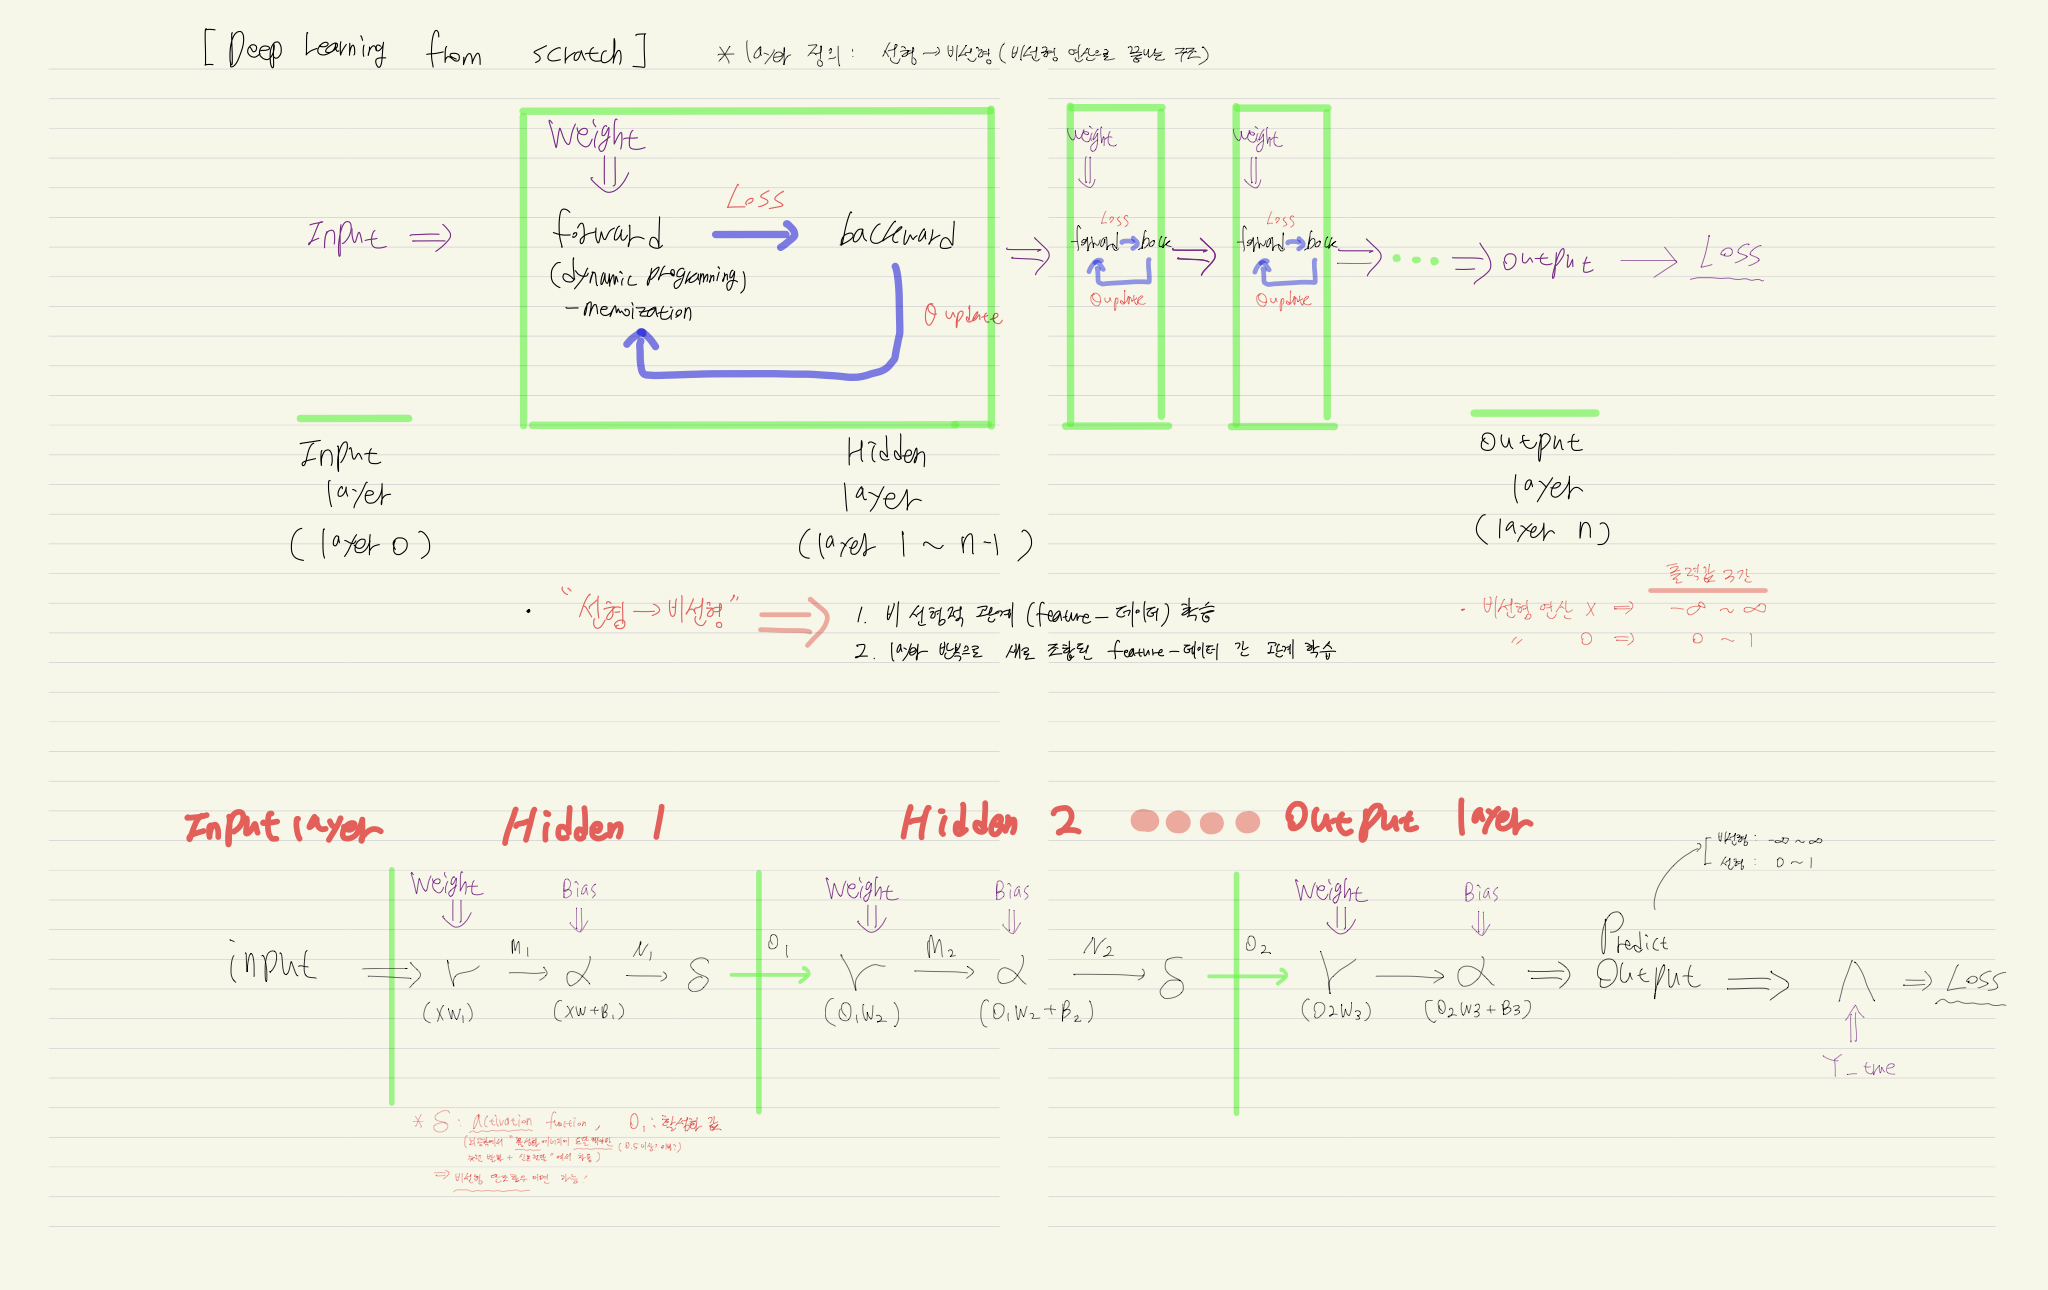

In [31]:
from IPython.display import Image
Image("/Users/kimjeongseob/Desktop/Study/1.Study/2. with computer/3.Deep_Learning_code/5. Deep Learning from Scratch/img/IMG_0037.jpg")

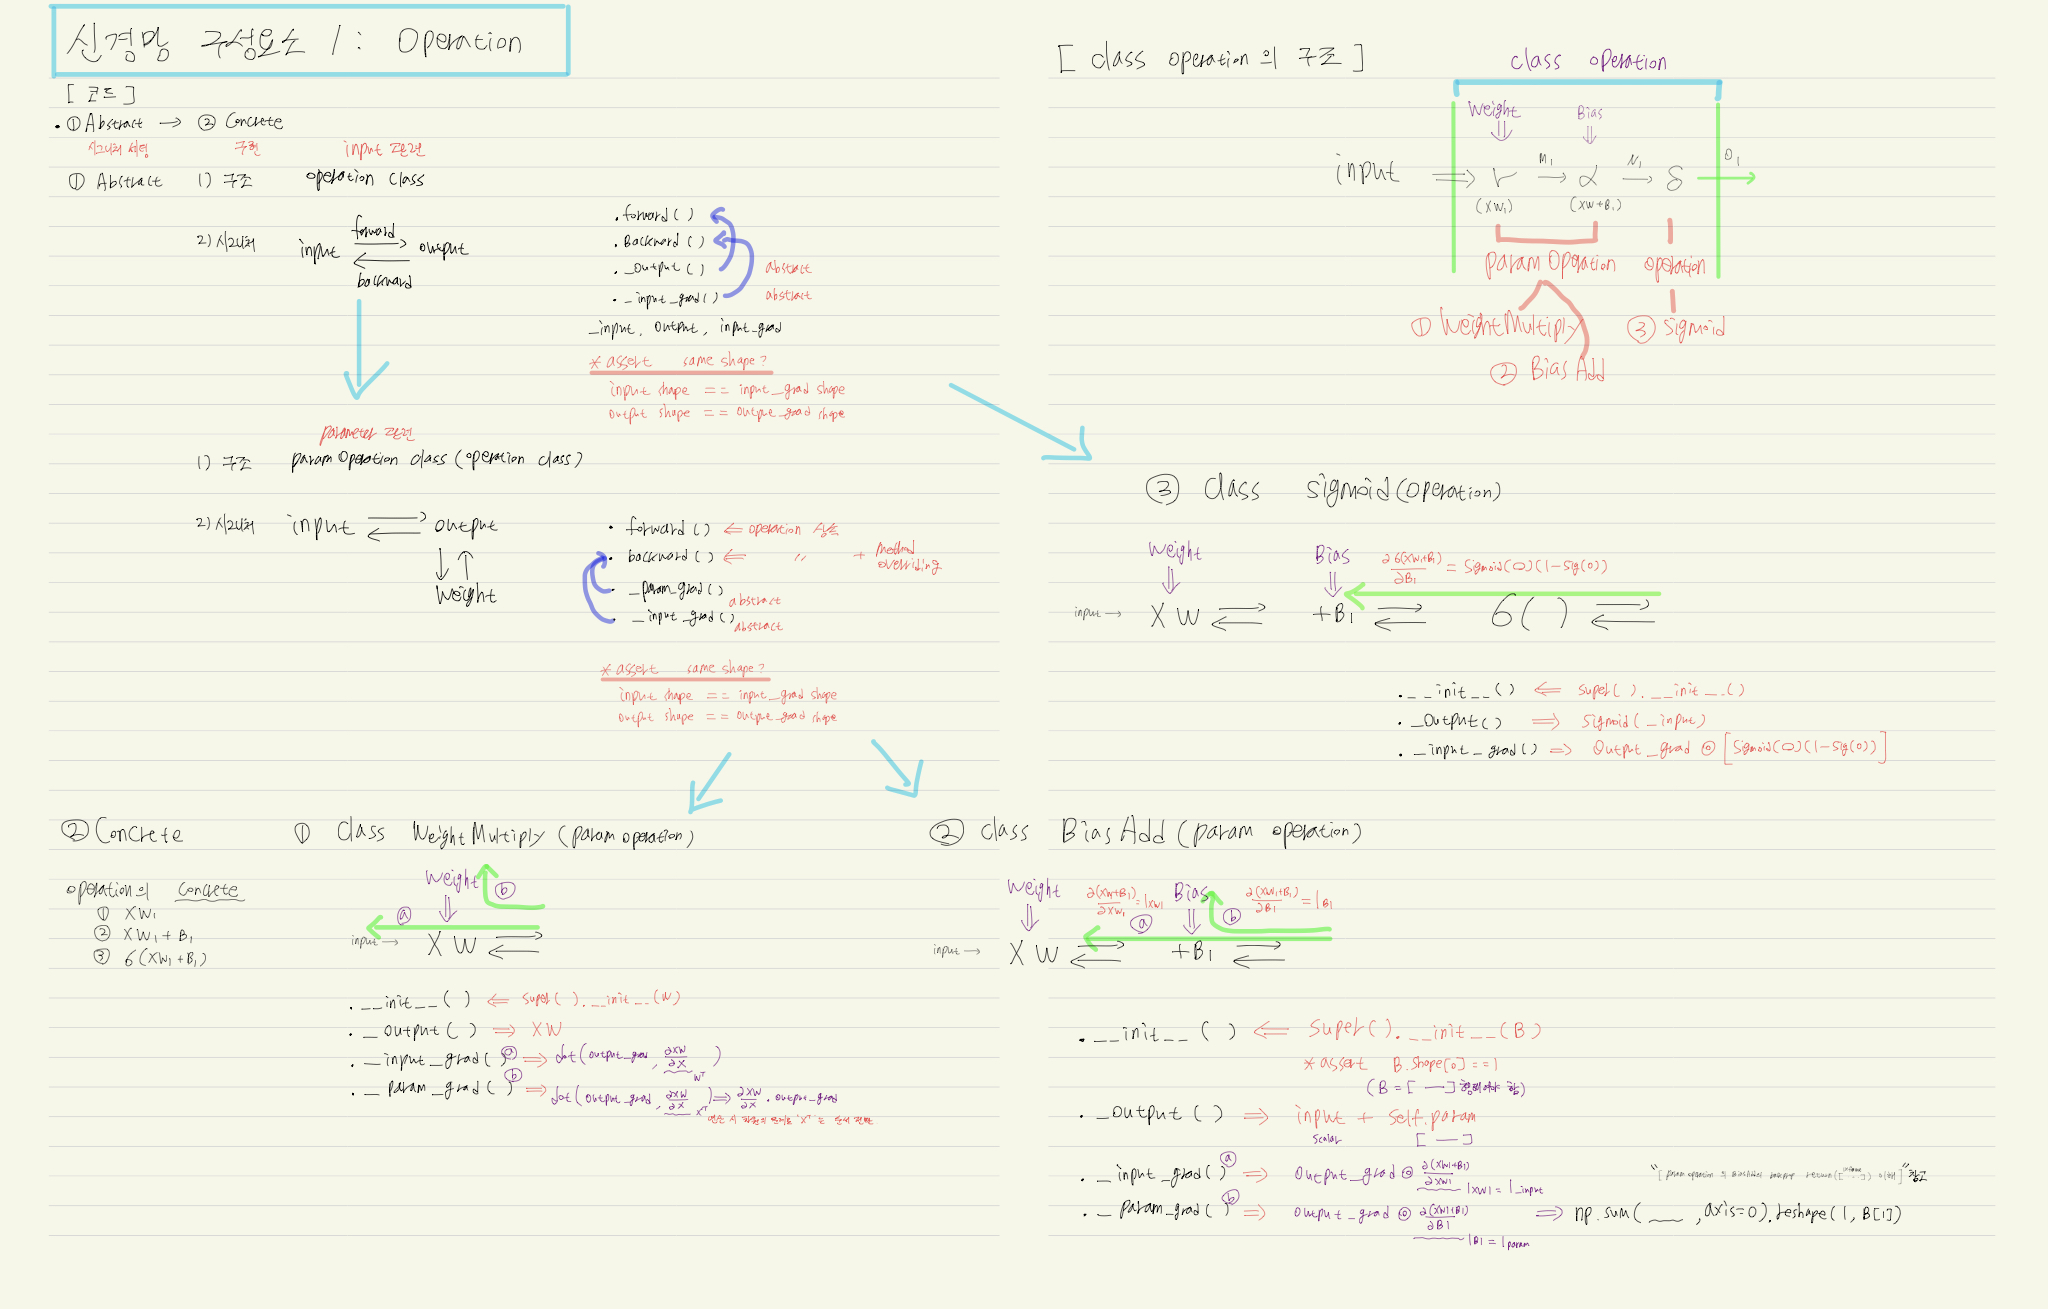

In [32]:
from IPython.display import Image
Image("/Users/kimjeongseob/Desktop/Study/1.Study/2. with computer/3.Deep_Learning_code/5. Deep Learning from Scratch/img/IMG_0038.jpg")

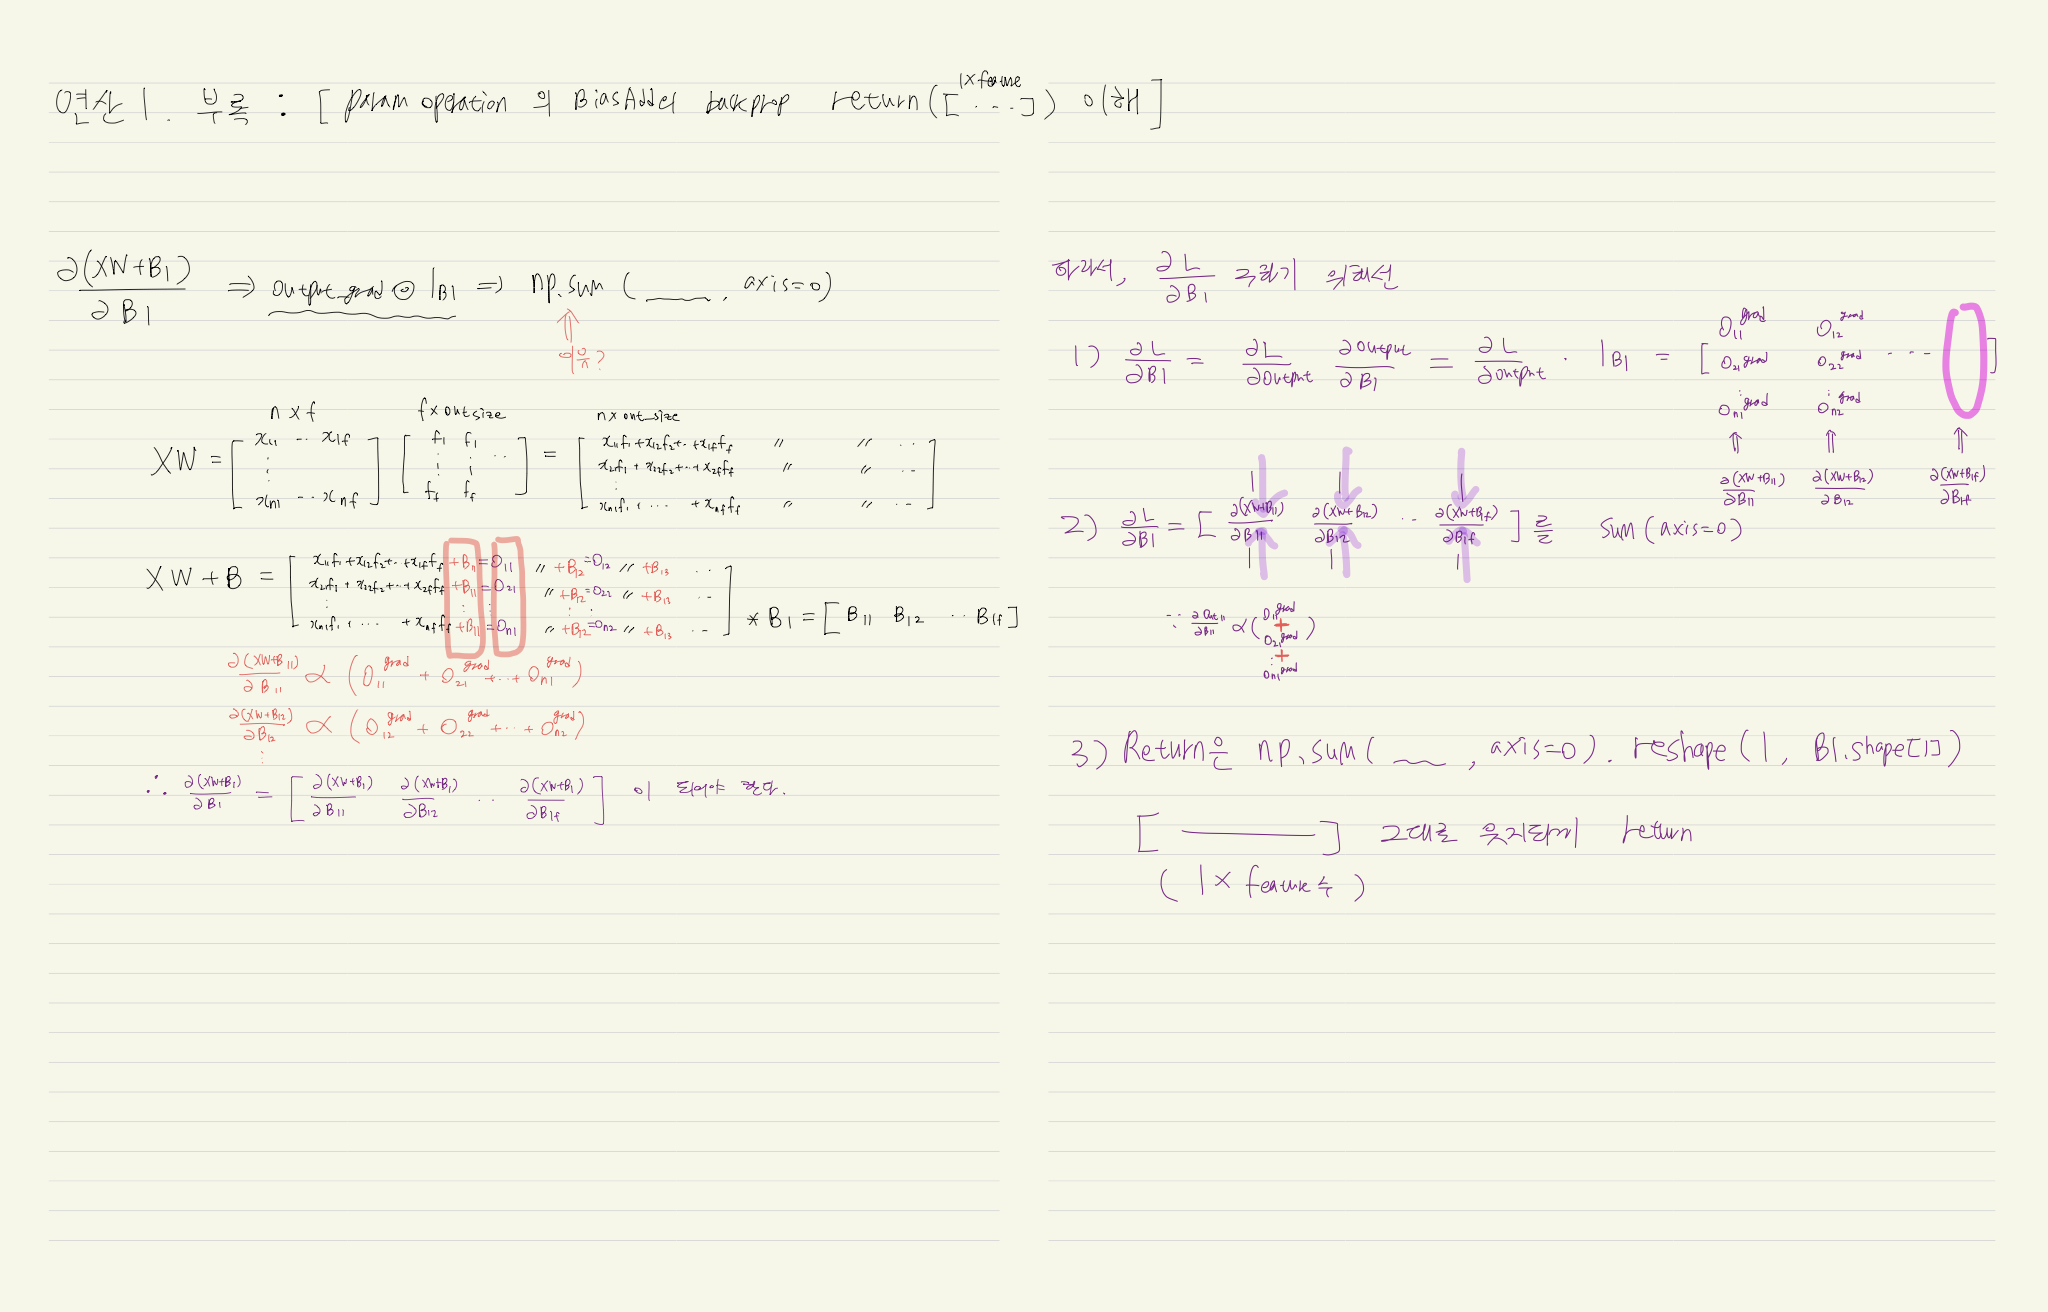

In [33]:
from IPython.display import Image
Image("/Users/kimjeongseob/Desktop/Study/1.Study/2. with computer/3.Deep_Learning_code/5. Deep Learning from Scratch/img/IMG_0039.jpg")

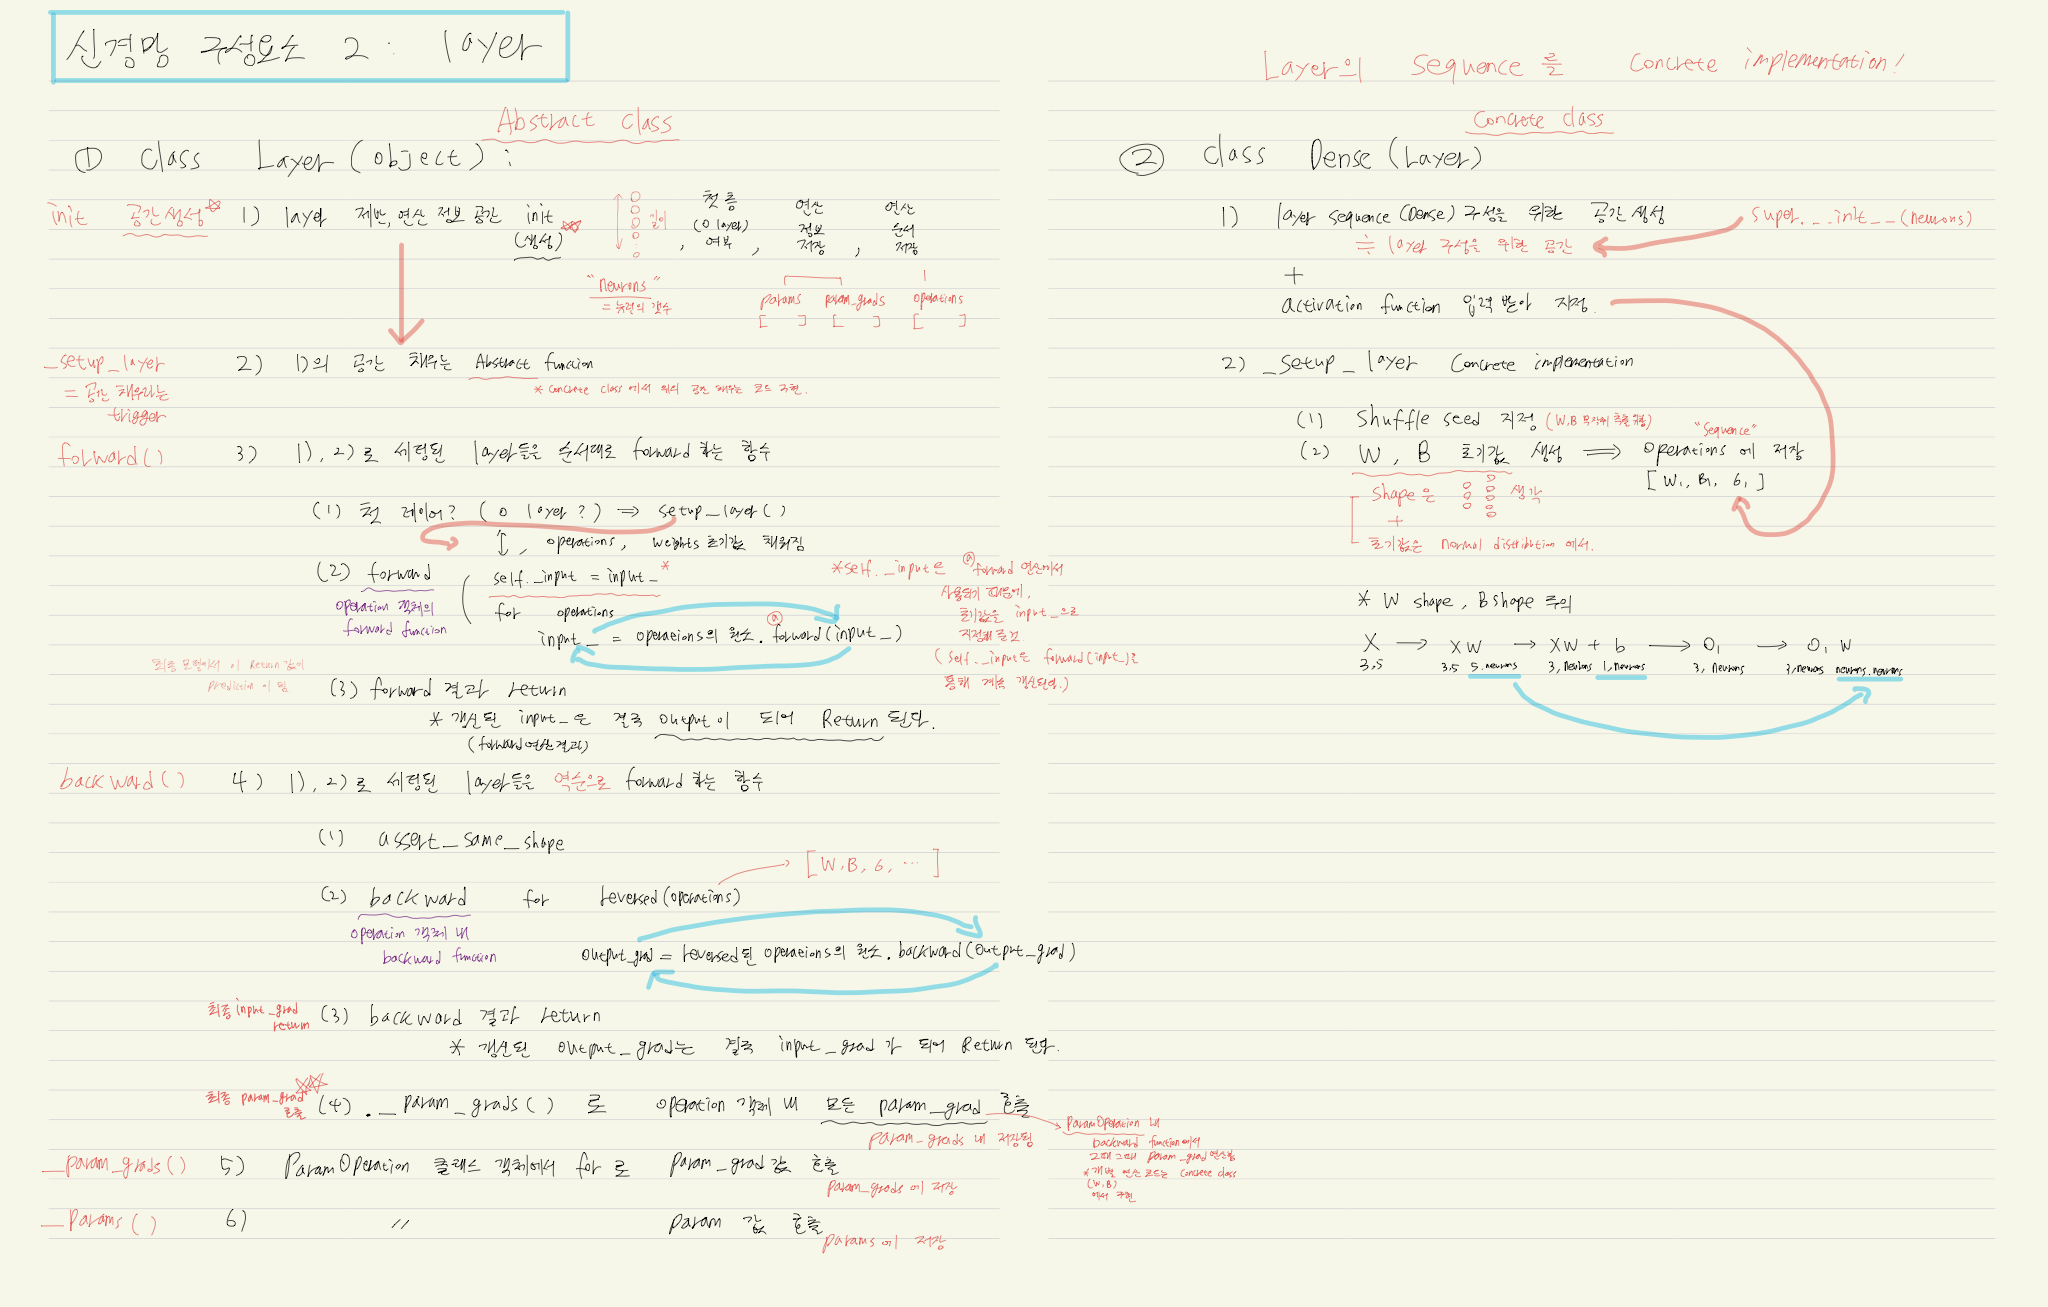

In [34]:
from IPython.display import Image
Image("/Users/kimjeongseob/Desktop/Study/1.Study/2. with computer/3.Deep_Learning_code/5. Deep Learning from Scratch/img/IMG_0040.jpg")

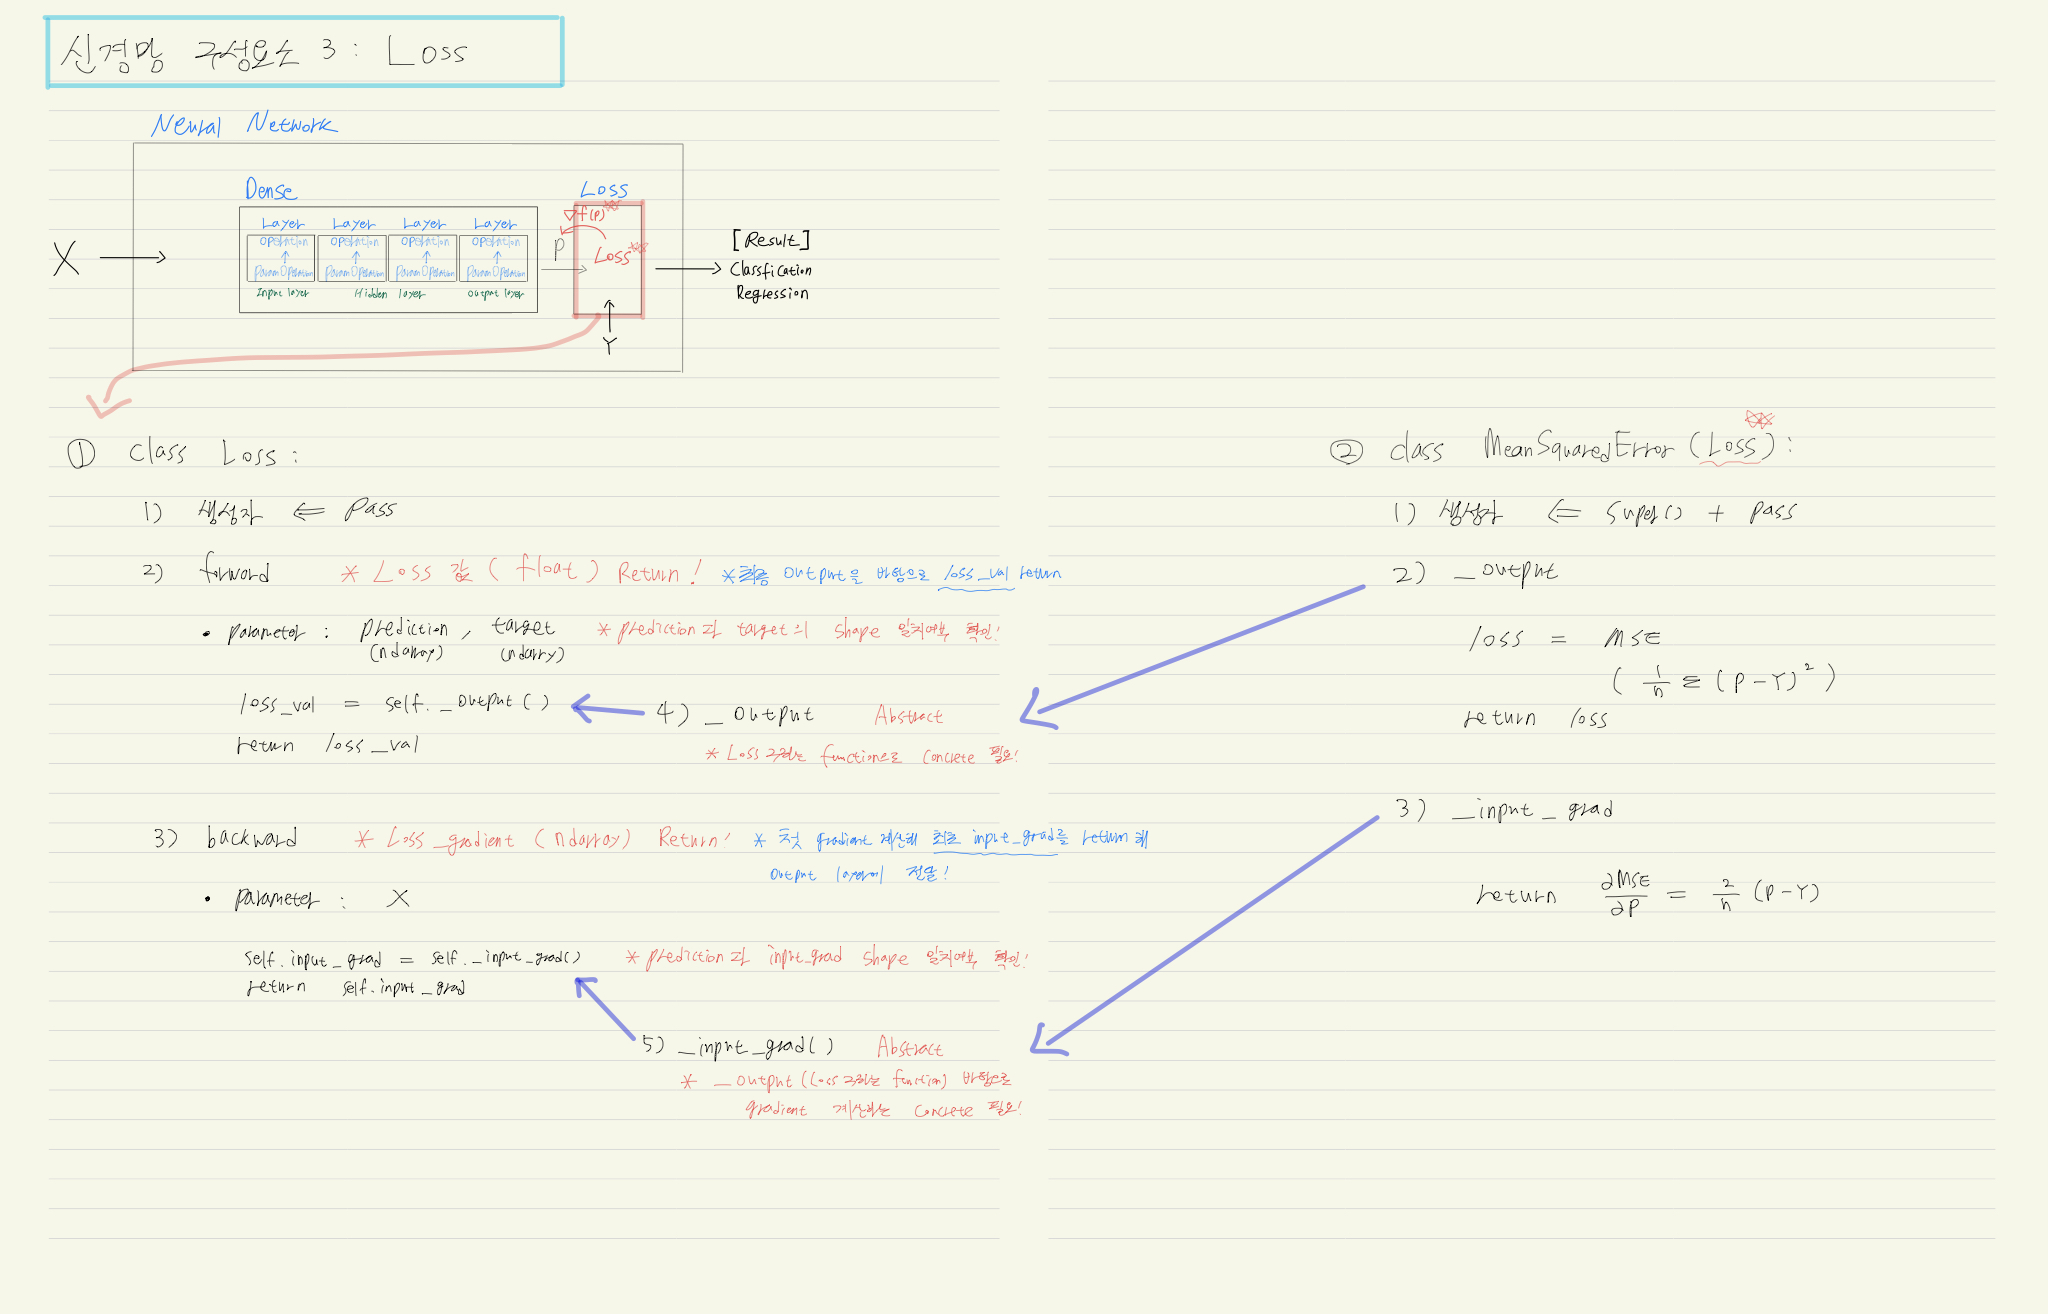

In [35]:
from IPython.display import Image
Image("/Users/kimjeongseob/Desktop/Study/1.Study/2. with computer/3.Deep_Learning_code/5. Deep Learning from Scratch/img/IMG_0041.jpg")

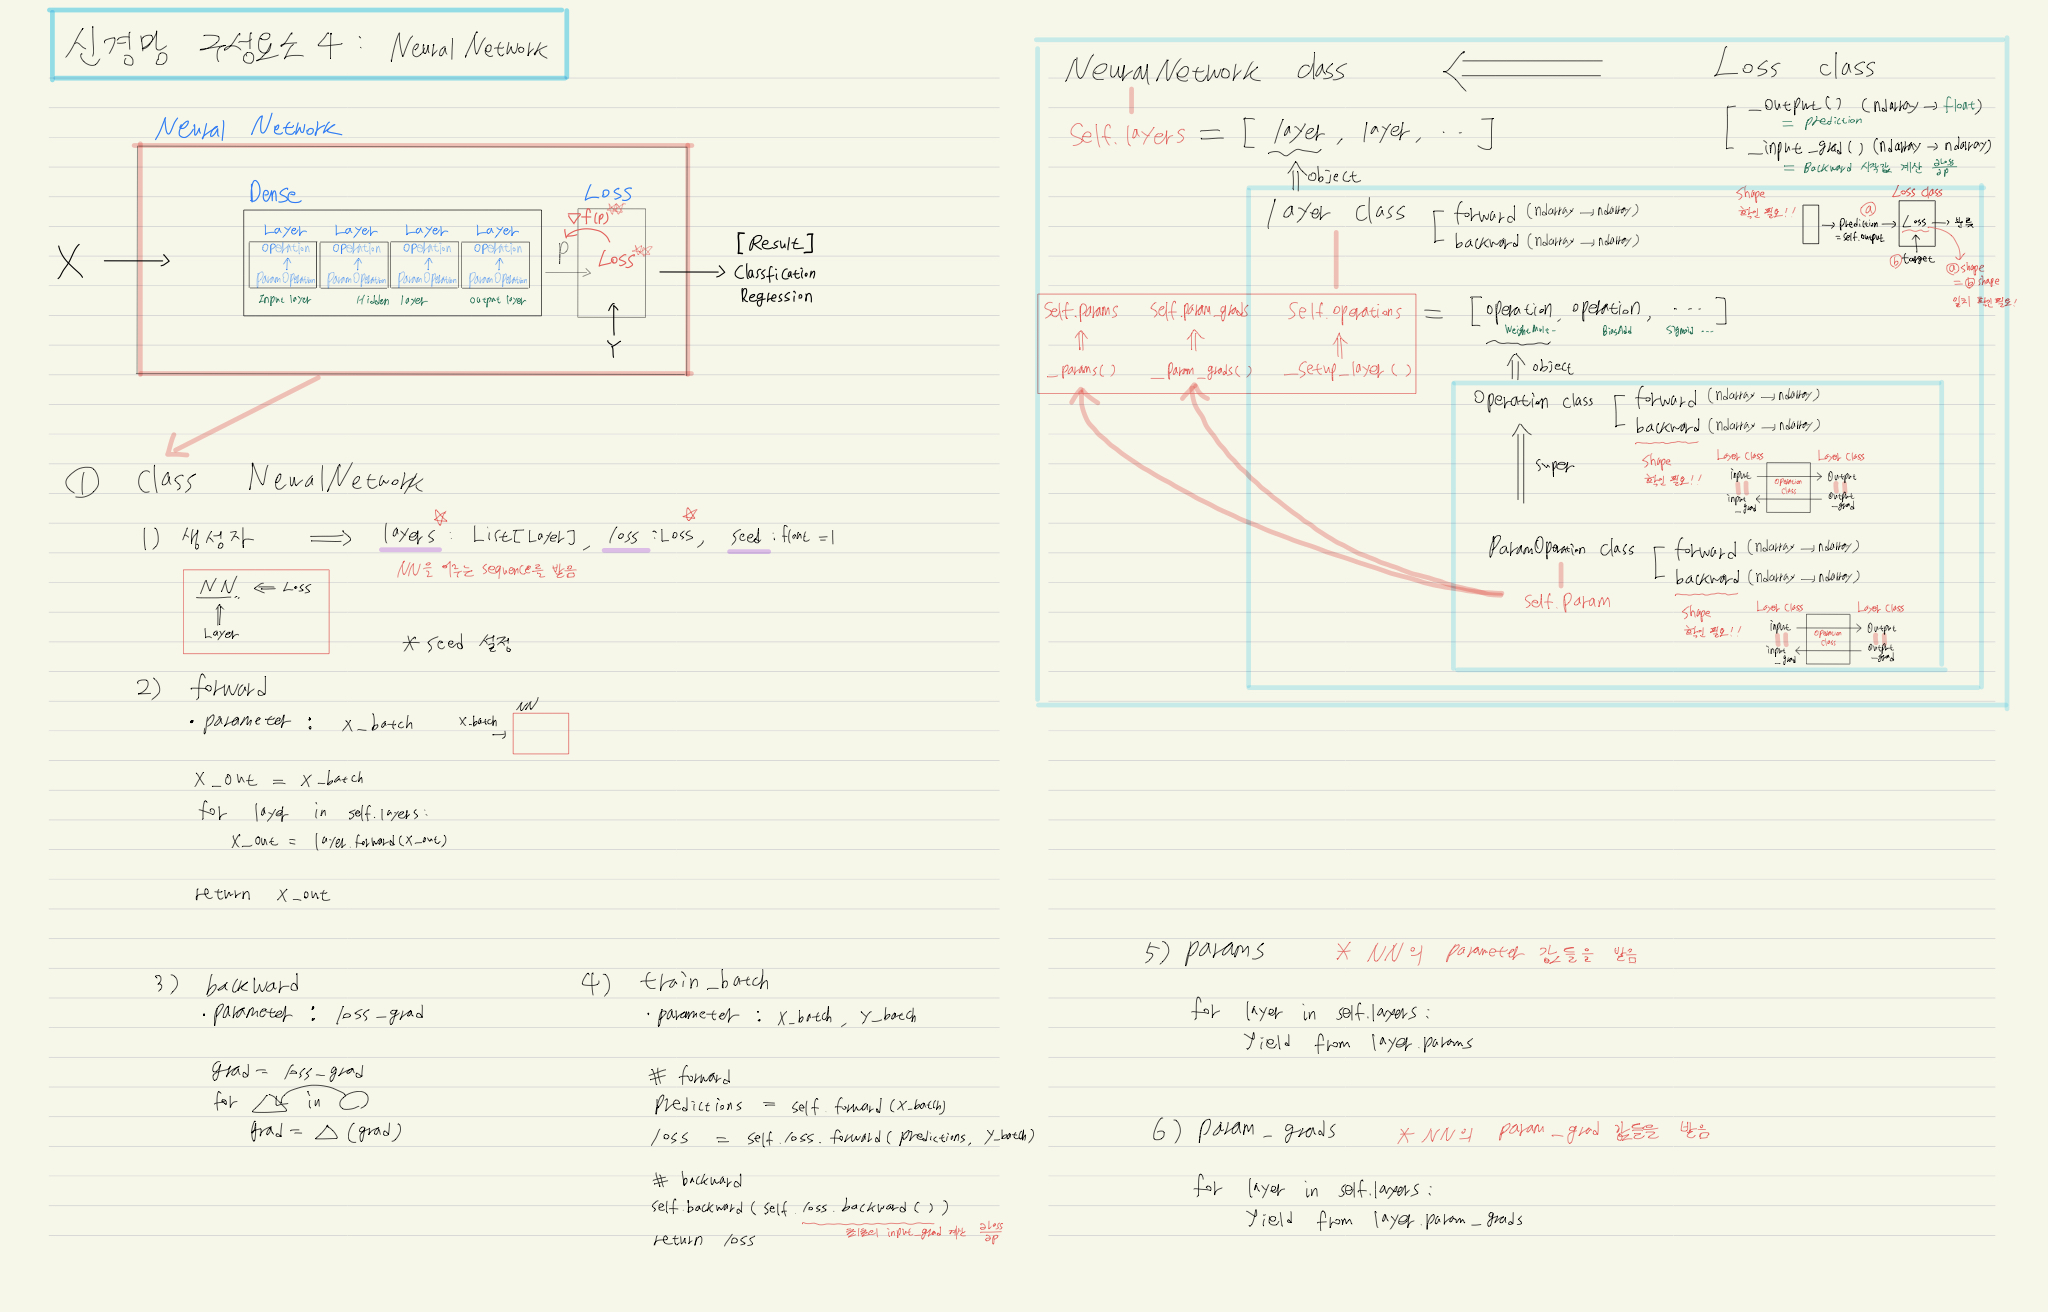

In [36]:
from IPython.display import Image
Image("/Users/kimjeongseob/Desktop/Study/1.Study/2. with computer/3.Deep_Learning_code/5. Deep Learning from Scratch/img/IMG_0042.jpg")

# MNIST digit classification

In [37]:
import sys
# 예제 파일 경로로 수정한 다음 주석 해제
sys.path.append(r'/Users/kimjeongseob/Desktop/Study/1.Study/2. with computer/3.Deep_Learning_code/5. Deep Learning from Scratch')

In [38]:
import numpy as np

In [39]:
%load_ext autoreload
%autoreload 2

In [41]:
mnist.init() # 최초 실행시 주석 해제, 이후 다시 주석 처리할 것

Download complete.
Save complete.


In [43]:
X_train, y_train, X_test, y_test = mnist.load()

In [44]:
num_labels = len(y_train)
num_labels

60000

In [45]:
# 원-핫 인코딩
num_labels = len(y_train)
train_labels = np.zeros((num_labels, 10))
for i in range(num_labels):
    train_labels[i][y_train[i]] = 1

num_labels = len(y_test)
test_labels = np.zeros((num_labels, 10))
for i in range(num_labels):
    test_labels[i][y_test[i]] = 1

In [46]:
X_train, X_test = X_train - np.mean(X_train), X_test - np.mean(X_train)

In [47]:
np.min(X_train), np.max(X_train), np.min(X_test), np.max(X_test)

(-33.318421449829934,
 221.68157855017006,
 -33.318421449829934,
 221.68157855017006)

In [48]:
X_train, X_test = X_train / np.std(X_train), X_test / np.std(X_train)

In [49]:
np.min(X_train), np.max(X_train), np.min(X_test), np.max(X_test)

(-0.424073894391566, 2.821543345689335, -0.424073894391566, 2.821543345689335)

In [50]:
def calc_accuracy_model(model, test_set):
    return print(f'''모델 검증을 위한 정확도: {np.equal(np.argmax(model.forward(test_set, inference=True), axis=1), y_test).sum() * 100.0 / test_set.shape[0]:.2f}%''')

## 1. Activation / Loss function

### 1) Sigmoid + MSE

In [51]:
model = NeuralNetwork(
    layers=[Dense(neurons=89, 
                  activation=Tanh()),
            Dense(neurons=10, 
                  activation=Sigmoid())],
            loss = MeanSquaredError(normalize=False), 
seed=20190119)

trainer = Trainer(model, SGD(0.1))
trainer.fit(X_train, train_labels, X_test, test_labels,
            epochs = 50,
            eval_every = 10,
            seed=20190119,
            batch_size=60);
print()
calc_accuracy_model(model, X_test)

10에폭에서 검증 데이터에 대한 손실값: 0.611
20에폭에서 검증 데이터에 대한 손실값: 0.428
30에폭에서 검증 데이터에 대한 손실값: 0.389
40에폭에서 검증 데이터에 대한 손실값: 0.374
50에폭에서 검증 데이터에 대한 손실값: 0.366

모델 검증을 위한 정확도: 72.58%


### 2) Sigmoid + CrossEntropy

In [52]:
model = NeuralNetwork(
    layers=[Dense(neurons=89, 
                  activation=Sigmoid()),
            Dense(neurons=10, 
                  activation=Linear())],
            loss = SoftmaxCrossEntropy(), 
seed=20190119)

trainer = Trainer(model, SGD(0.1))
trainer.fit(X_train, train_labels, X_test, test_labels,
            epochs = 130,
            eval_every = 1,
            seed=20190119,
            batch_size=60);
print()
calc_accuracy_model(model, X_test)

1에폭에서 검증 데이터에 대한 손실값: 1.285
2에폭에서 검증 데이터에 대한 손실값: 0.970
3에폭에서 검증 데이터에 대한 손실값: 0.836
4에폭에서 검증 데이터에 대한 손실값: 0.763
5에폭에서 검증 데이터에 대한 손실값: 0.712
6에폭에서 검증 데이터에 대한 손실값: 0.679
7에폭에서 검증 데이터에 대한 손실값: 0.651
8에폭에서 검증 데이터에 대한 손실값: 0.631
9에폭에서 검증 데이터에 대한 손실값: 0.617
10에폭에서 검증 데이터에 대한 손실값: 0.599
11에폭에서 검증 데이터에 대한 손실값: 0.588
12에폭에서 검증 데이터에 대한 손실값: 0.576
13에폭에서 검증 데이터에 대한 손실값: 0.568
14에폭에서 검증 데이터에 대한 손실값: 0.557
15에폭에서 검증 데이터에 대한 손실값: 0.550
16에폭에서 검증 데이터에 대한 손실값: 0.544
17에폭에서 검증 데이터에 대한 손실값: 0.537
18에폭에서 검증 데이터에 대한 손실값: 0.533
19에폭에서 검증 데이터에 대한 손실값: 0.529
20에폭에서 검증 데이터에 대한 손실값: 0.523
21에폭에서 검증 데이터에 대한 손실값: 0.517
22에폭에서 검증 데이터에 대한 손실값: 0.512
23에폭에서 검증 데이터에 대한 손실값: 0.507

24에폭에서 손실값이 증가했다. 마지막으로 측정한 손실값은 23 에폭까지 학습된 모델에서 계산된 0.507이다.

모델 검증을 위한 정확도: 91.04%


### 3) ReLU + CrossEntropy

In [53]:
model = NeuralNetwork(
    layers=[Dense(neurons=89, 
                  activation=ReLU()),
            Dense(neurons=10, 
                  activation=Linear())],
            loss = SoftmaxCrossEntropy(), 
seed=20190119)

trainer = Trainer(model, SGD(0.1))
trainer.fit(X_train, train_labels, X_test, test_labels,
            epochs = 50,
            eval_every = 10,
            seed=20190119,
            batch_size=60);
print()
calc_accuracy_model(model, X_test)

10에폭에서 검증 데이터에 대한 손실값: 5.955

20에폭에서 손실값이 증가했다. 마지막으로 측정한 손실값은 10 에폭까지 학습된 모델에서 계산된 5.955이다.

모델 검증을 위한 정확도: 76.38%


### 4) Tanh + CrossEntropy

In [54]:
model = NeuralNetwork(
    layers=[Dense(neurons=89, 
                  activation=Tanh()),
            Dense(neurons=10, 
                  activation=Linear())],
            loss = SoftmaxCrossEntropy(), 
seed=20190119)

trainer = Trainer(model, SGD(0.1))
trainer.fit(X_train, train_labels, X_test, test_labels,
            epochs = 50,
            eval_every = 10,
            seed=20190119,
            batch_size=60);
print()
calc_accuracy_model(model, X_test)

10에폭에서 검증 데이터에 대한 손실값: 0.630
20에폭에서 검증 데이터에 대한 손실값: 0.574
30에폭에서 검증 데이터에 대한 손실값: 0.549
40에폭에서 검증 데이터에 대한 손실값: 0.546

50에폭에서 손실값이 증가했다. 마지막으로 측정한 손실값은 40 에폭까지 학습된 모델에서 계산된 0.546이다.

모델 검증을 위한 정확도: 91.01%


## 2. Optimizer 

### 1) SGD momentum + Linear activation

In [55]:
model = NeuralNetwork(
    layers=[Dense(neurons=89, 
                  activation=Sigmoid()),
            Dense(neurons=10, 
                  activation=Linear())],
            loss = SoftmaxCrossEntropy(), 
seed=20190119)

optim = SGDMomentum(0.1, momentum=0.9)

trainer = Trainer(model, SGDMomentum(0.1, momentum=0.9))
trainer.fit(X_train, train_labels, X_test, test_labels,
            epochs = 50,
            eval_every = 1,
            seed=20190119,
            batch_size=60);

calc_accuracy_model(model, X_test)

1에폭에서 검증 데이터에 대한 손실값: 0.615
2에폭에서 검증 데이터에 대한 손실값: 0.489
3에폭에서 검증 데이터에 대한 손실값: 0.444

4에폭에서 손실값이 증가했다. 마지막으로 측정한 손실값은 3 에폭까지 학습된 모델에서 계산된 0.444이다.
모델 검증을 위한 정확도: 92.12%


### 2) SGD momentum + Sigmoid activation

In [56]:
model = NeuralNetwork(
    layers=[Dense(neurons=89, 
                  activation=Tanh()),
            Dense(neurons=10, 
                  activation=Linear())],
            loss = SoftmaxCrossEntropy(), 
seed=20190119)

optim = SGD(0.1)

optim = SGDMomentum(0.1, momentum=0.9)

trainer = Trainer(model, SGDMomentum(0.1, momentum=0.9))
trainer.fit(X_train, train_labels, X_test, test_labels,
            epochs = 50,
            eval_every = 10,
            seed=20190119,
            batch_size=60);

calc_accuracy_model(model, X_test)

10에폭에서 검증 데이터에 대한 손실값: 0.441
20에폭에서 검증 데이터에 대한 손실값: 0.351
30에폭에서 검증 데이터에 대한 손실값: 0.345
40에폭에서 검증 데이터에 대한 손실값: 0.338

50에폭에서 손실값이 증가했다. 마지막으로 측정한 손실값은 40 에폭까지 학습된 모델에서 계산된 0.338이다.
모델 검증을 위한 정확도: 95.51%


## 3. Learning-rate Decay

- Exponential
- Linear

### 1) Linear decay

In [57]:
model = NeuralNetwork(
    layers=[Dense(neurons=89, 
                  activation=Tanh()),
            Dense(neurons=10, 
                  activation=Linear())],
            loss = SoftmaxCrossEntropy(), 
seed=20190119)

optimizer = SGDMomentum(0.15, momentum=0.9, final_lr = 0.05, decay_type='linear')

trainer = Trainer(model, optimizer)
trainer.fit(X_train, train_labels, X_test, test_labels,
            epochs = 50,
            eval_every = 10,
            seed=20190119,
            batch_size=60);

calc_accuracy_model(model, X_test)

10에폭에서 검증 데이터에 대한 손실값: 0.403
20에폭에서 검증 데이터에 대한 손실값: 0.343
30에폭에서 검증 데이터에 대한 손실값: 0.282

40에폭에서 손실값이 증가했다. 마지막으로 측정한 손실값은 30 에폭까지 학습된 모델에서 계산된 0.282이다.
모델 검증을 위한 정확도: 95.91%


### 2) Exponential decay

In [58]:
model = NeuralNetwork(
    layers=[Dense(neurons=89, 
                  activation=Tanh()),
            Dense(neurons=10, 
                  activation=Linear())],
            loss = SoftmaxCrossEntropy(), 
seed=20190119)

optimizer = SGDMomentum(0.2, 
                        momentum=0.9, 
                        final_lr = 0.05, 
                        decay_type='exponential')

trainer = Trainer(model, optimizer)
trainer.fit(X_train, train_labels, X_test, test_labels,
            epochs = 50,
            eval_every = 10,
            seed=20190119,
            batch_size=60);

calc_accuracy_model(model, X_test)

10에폭에서 검증 데이터에 대한 손실값: 0.461
20에폭에서 검증 데이터에 대한 손실값: 0.323
30에폭에서 검증 데이터에 대한 손실값: 0.284

40에폭에서 손실값이 증가했다. 마지막으로 측정한 손실값은 30 에폭까지 학습된 모델에서 계산된 0.284이다.
모델 검증을 위한 정확도: 96.06%


## 4. Weight initialize

- glorot method

In [59]:
model = NeuralNetwork(
    layers=[Dense(neurons=89, 
                  activation=Tanh(),
                  weight_init="glorot"),
            Dense(neurons=10, 
                  activation=Linear(),
                  weight_init="glorot")],
            loss = SoftmaxCrossEntropy(), 
seed=20190119)

optimizer = SGDMomentum(0.15, momentum=0.9, final_lr = 0.05, decay_type='linear')

trainer = Trainer(model, optimizer)
trainer.fit(X_train, train_labels, X_test, test_labels,
       epochs = 50,
       eval_every = 10,
       seed=20190119,
           batch_size=60,
           early_stopping=True);

calc_accuracy_model(model, X_test)

10에폭에서 검증 데이터에 대한 손실값: 0.305
20에폭에서 검증 데이터에 대한 손실값: 0.264
30에폭에서 검증 데이터에 대한 손실값: 0.245

40에폭에서 손실값이 증가했다. 마지막으로 측정한 손실값은 30 에폭까지 학습된 모델에서 계산된 0.245이다.
모델 검증을 위한 정확도: 96.96%


## 5. Dropout


In [60]:
model = NeuralNetwork(
    layers=[Dense(neurons=89, 
                  activation=Tanh(),
                  weight_init="glorot",
                  dropout=0.8),
            Dense(neurons=10, 
                  activation=Linear(),
                  weight_init="glorot")],
            loss = SoftmaxCrossEntropy(), 
seed=20190119)

trainer = Trainer(model, SGDMomentum(0.2, momentum=0.9, final_lr = 0.05, decay_type='exponential'))
trainer.fit(X_train, train_labels, X_test, test_labels,
       epochs = 50,
       eval_every = 10,
       seed=20190119,
           batch_size=60,
           early_stopping=True);

calc_accuracy_model(model, X_test)

10에폭에서 검증 데이터에 대한 손실값: 0.285
20에폭에서 검증 데이터에 대한 손실값: 0.232
30에폭에서 검증 데이터에 대한 손실값: 0.199
40에폭에서 검증 데이터에 대한 손실값: 0.196

50에폭에서 손실값이 증가했다. 마지막으로 측정한 손실값은 40 에폭까지 학습된 모델에서 계산된 0.196이다.
모델 검증을 위한 정확도: 96.95%


**Dropout 미실시**

In [61]:
model = NeuralNetwork(
    layers=[Dense(neurons=89, 
                  activation=Tanh(),
                  weight_init="glorot",
                  ),
            Dense(neurons=10, 
                  activation=Linear(),
                  weight_init="glorot")],
            loss = SoftmaxCrossEntropy(), 
seed=20190119)

trainer = Trainer(model, SGDMomentum(0.2, momentum=0.9, final_lr = 0.05, decay_type='exponential'))
trainer.fit(X_train, train_labels, X_test, test_labels,
       epochs = 50,
       eval_every = 10,
       seed=20190119,
           batch_size=60,
           early_stopping=True);

calc_accuracy_model(model, X_test)

10에폭에서 검증 데이터에 대한 손실값: 0.352
20에폭에서 검증 데이터에 대한 손실값: 0.280
30에폭에서 검증 데이터에 대한 손실값: 0.244

40에폭에서 손실값이 증가했다. 마지막으로 측정한 손실값은 30 에폭까지 학습된 모델에서 계산된 0.244이다.
모델 검증을 위한 정확도: 96.71%
